In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
synopsis = pd.read_csv('unique_id.csv')[['movieId', 'Synopsis']].set_index('movieId')

In [3]:
movie_title = []
year = []

for element in movies['title']:
    match = re.match(r"(.+) \((\d{4})\)", element)
    # Vérifier si la correspondance a été trouvée
    if match:
        # Ajouter le nom du film à la liste des noms de films
        movie_title.append(match.group(1))
        
        # Ajouter l'année à la liste des années
        year.append(match.group(2))
    else:
        # Si aucune correspondance n'a été trouvée, ajouter des valeurs par défaut
        movie_title.append(None)
        year.append(None)

movies['title'] = movie_title
movies['year'] = year

movies['genres'] = movies['genres'].replace('(no genres listed)', 'Not specified')
movies['genres'] = movies['genres'].apply(lambda row: row.split())

movies['title'] = movies['title'].str.replace(r'\s*\([^)]*\)', '')

movies = movies.drop_duplicates(subset='title')

In [4]:
# We keep mostly rated movies and mostly ratings users
# We define mostly as frequency >= to the thrid quartile 
# using describe we find that the third quartile lies at count = 36
threshold = 36

filter_movies = ratings['movieId'].value_counts() >= threshold
filter_movies = filter_movies[filter_movies].index.tolist()

filter_users = ratings['userId'].value_counts() > threshold
filter_users = filter_users[filter_users].index.tolist()

ratings_new = ratings[(ratings['movieId'].isin(filter_movies)) & (ratings['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(ratings_new.shape))

The original data frame shape:	(25000095, 4)
The new data frame shape:	(23599860, 4)


In [5]:
db = movies.merge(ratings_new, on='movieId').set_index('movieId') 

db.drop(columns=['timestamp'], inplace=True)

<Axes: >

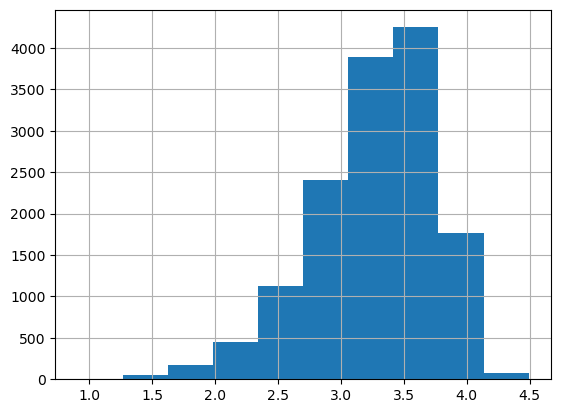

In [6]:
ratings_agg = db.groupby(['movieId'])['rating'].agg(['count', 'mean'])

ratings_agg['mean'].hist()

In [7]:
C = ratings_agg['count'].mean()
m = ratings_agg['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

In [8]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
ratings_agg = ratings_agg.merge(bayesian_avg_ratings, on='movieId')

<Axes: >

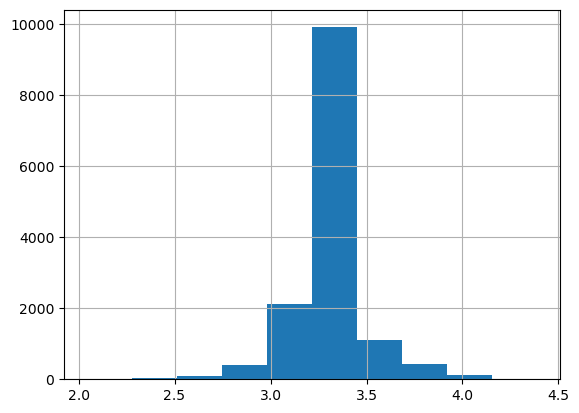

In [9]:
ratings_agg['bayesian_avg'].hist()

In [10]:
db = db.merge(synopsis, on='movieId')
db.shape

(23019525, 6)

In [11]:
len(list(db[db['Synopsis']!='Description non disponible']['title'].unique()))

12245

In [12]:
len(list(db[db['Synopsis']=='Description non disponible']['title'].unique()))

1951

In [13]:
db.to_csv('movie_db_clean.csv')